<h1 style="font-size:30px;">KerasCV YOLOv8 Weighted Boxes Fusion</h1>

## Install Dependencies

In [1]:
!pip install -q pycocotools ensemble-boxes
!pip install --upgrade git+https://github.com/keras-team/keras-cv -q

## Imports

In [2]:
import os
import glob
import requests
from zipfile import ZipFile

import itertools
import csv
import cv2

import numpy as np
import tensorflow as tf
import keras_cv
from keras_cv import bounding_box

from ensemble_boxes import weighted_boxes_fusion, nms

import matplotlib.pyplot as plt

2023-10-20 13:38:38.368616: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-20 13:38:38.395338: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-20 13:38:38.766765: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using TensorFlow backend


## System configuration

In [3]:
def system_config():

    # Get list of GPUs.
    gpu_devices = tf.config.list_physical_devices('GPU')

    os.environ["CUDA_VISIBLE_DEVICES"] = '0'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    # Grow the memory usage as the process needs it.
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)

    # Enable using cudNN.
    os.environ['TF_USE_CUDNN'] = "true"

system_config()

2023-10-20 13:38:39.741812: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-20 13:38:39.760520: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-20 13:38:39.760635: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Download and Extract Data and Model Checkpoints

In [4]:
# Download and dataset.
def download_and_unzip(url, save_path):

    print("Downloading and extracting assets...", end="")
    file = requests.get(url)
    open(save_path, "wb").write(file.content)

    try:
        # Extract zipfile.
        if save_path.endswith(".zip"):
            with ZipFile(save_path) as zip:
                zip.extractall(os.path.split(save_path)[0])

        print("Done")
    except:
        print("Invalid file")

In [5]:
DATASET_URL = r"https://www.dropbox.com/scl/fi/3gp2mqp1okiyevwnr5pbc/global-wheat-detection.zip?rlkey=kbui4gafys0lok8dqj54li6bj&dl=1"
DATASET_DIR = "global-wheat-detection"
DATASET_ZIP_PATH = os.path.join(os.getcwd(), f"{DATASET_DIR}.zip")

CHECKPOINT_URL = r"https://www.dropbox.com/scl/fi/bicrtoufvj5zxc0jqy4cj/yolov8-models-kerascv.zip?rlkey=majuikz2z9oofchbkw5uw4amu&dl=1"
CHECKPOINT_DIR = "yolov8-models-kerascv"
CKPT_ZIP_PATH = os.path.join(os.getcwd(), f"{CHECKPOINT_DIR}.zip")

# Download if dataset does not exists.
if not os.path.exists(DATASET_DIR):
    download_and_unzip(DATASET_URL, DATASET_ZIP_PATH)
    os.remove(DATASET_ZIP_PATH)


# Download if dataset does not exists.
if not os.path.exists(CHECKPOINT_DIR):
    download_and_unzip(CHECKPOINT_URL, CKPT_ZIP_PATH)
    os.remove(CKPT_ZIP_PATH)

## Map ImageID with Resoultions

In [6]:
def get_data_resolution(image_dir_path, img_files):
    
    image_res = {} 
    
    for img_file in img_files:
        img_filepath = os.path.join(image_dir_path, img_file)
        
        image_id = img_file.strip().split(".")[0]
        image = cv2.imread(img_filepath)
        
        image_res[image_id] = image.shape[:2]
        
    return image_res

## Preprocess Input Image Data

In [7]:
def read_preprocess_image(image_path, resize):
    
    image_raw = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_raw, channels=3)

    og_image_shape = tf.shape(image)[:2]
    
    image = tf.image.resize(images=image, size=resize, method = "bicubic")
    image = tf.cast(tf.clip_by_value(image, 0., 255.), tf.float32)
    
    return image, og_image_shape.numpy()

## Resize Predicted Boxes to Original Dimensions

In [8]:
def denorm_boxes(bbox_coords, im_shape, resize):
    
    ratio_wh  = im_shape / resize

    im_shape_lst = im_shape.tolist()
    ratio_multipler = np.concatenate([ratio_wh, ratio_wh], axis=-1)

    bbox_resize = bbox_coords * ratio_multipler
    bbox_resize = np.clip(bbox_resize,
                          a_min=[0., 0., 0., 0.],
                          a_max=im_shape_lst+im_shape_lst
                          )
    
    return bbox_resize

## Obtain Model Predictions

In [9]:
def get_predictions(model, image_dir_path, image_filenames, resize=(832, 832)):
    
    all_pred_scores = {}
    all_pred_boxes = {}
    all_pred_classes = {}
 
    for image_file in image_filenames:
        img_filepath = os.path.join(image_dir_path, image_file)
        image_id = image_file.strip().split(".")[0]
        
        image_tensor, im_shape = read_preprocess_image(img_filepath, resize=resize)
        image_batch = tf.expand_dims(image_tensor, axis=0)
    
        pred_results = model.predict(image_batch, verbose=0)
        pred_batch = bounding_box.to_ragged(pred_results)

        pred_boxes = tf.squeeze(pred_batch["boxes"], axis=0).numpy()
        pred_confs = tf.squeeze(pred_batch["confidence"], axis=0).numpy()
        pred_cls = tf.squeeze(pred_batch["classes"], axis=0).numpy().astype("int")

        pred_boxes = denorm_boxes(pred_boxes, im_shape, resize)

        if not len(pred_boxes):
            all_pred_boxes[image_id] = []
            all_pred_classes[image_id] = []
            all_pred_scores[image_id] = []

        else:
            all_pred_scores[image_id] = np.expand_dims(pred_confs, axis=1)
            all_pred_boxes[image_id] = pred_boxes
            all_pred_classes[image_id] = np.expand_dims(pred_cls, axis=1)
    
    return all_pred_scores, all_pred_boxes, all_pred_classes

## Load YOLOv8 Model Weights

In [10]:
def load_model_weights(backbone_name, pred_decoder, weights_path, fpn_depth=2):

    backbone = keras_cv.models.YOLOV8Backbone.from_preset(
                    backbone_name, load_weights=False
                )
    
    detector = keras_cv.models.YOLOV8Detector(
                    num_classes=1,
                    bounding_box_format="xyxy",
                    backbone=backbone,
                    fpn_depth=fpn_depth,
                    prediction_decoder=pred_decoder
                )
    
    detector.load_weights(weights_path)

    return detector

## Initialize KerasCV YOLOv8 Models

In [11]:
prediction_decoder = keras_cv.layers.NonMaxSuppression(
                    bounding_box_format="xyxy",
                    from_logits=False,
                    iou_threshold=0.4,
                    confidence_threshold=0.22
                )

model_dict = dict()

ckpt_files = os.listdir(CHECKPOINT_DIR)

for file in ckpt_files:
    model_type = file.split("_")[-1].split(".")[0]
    backbone = f"yolo_v8_{model_type}_backbone_coco"
    if model_type == "l":
        fpn_depth = 3
    else:
        fpn_depth = 2
    model_dict["yolov8_"+model_type] = load_model_weights(
                                        backbone_name=backbone,
                                        pred_decoder=prediction_decoder,
                                        weights_path=os.path.join(
                                                    CHECKPOINT_DIR, file),
                                        fpn_depth=fpn_depth
                                      )


TEST_IMG_DIR = os.path.join(DATASET_DIR, "test")
test_image_files = os.listdir(TEST_IMG_DIR)

2023-10-20 13:38:39.907221: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-20 13:38:39.907363: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-20 13:38:39.907424: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Obtain Predictions across Models

In [12]:
data_res_dict = get_data_resolution(TEST_IMG_DIR, test_image_files)

CLASSES_DICT = {0:"wheat_head"}

pred_confs   = []
pred_boxes   = []
pred_classes = []

for model in model_dict.values():
    confs_scores, box_preds, cls_preds = get_predictions(model, TEST_IMG_DIR, test_image_files)
    pred_confs.append(confs_scores)
    pred_boxes.append(box_preds)
    pred_classes.append(cls_preds)

2023-10-20 13:38:46.213194: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-20 13:38:46.285911: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


## Perform Weighted Boxes Fusion (WBF)

In [13]:
def perform_weighted_boxes_fusion(
        pred_confs_models,
        pred_boxes_models,
        pred_classes_models,
        resolution_dict, 
        IOU_THRESH=0.50,
        CONF_THRESH=0.45,
        FINAL_CONF_THRESH=.40):
    
    wbf_boxes_dict = {}
    wbf_scores_dict = {}
    
    for image_id, res in resolution_dict.items():
        
        res_array = np.array([res[1], res[0], res[1], res[0]]) # [W, H, W, H]

        all_model_boxes   = []
        all_model_scores  = []
        all_model_classes = []

        for boxes, scores, classes in zip(pred_boxes_models, pred_confs_models, pred_classes_models):
            pred_boxes_norm = (boxes[image_id] / res_array).clip(min=0., max=1.)
            scores_model = scores[image_id]
            classes_model = classes[image_id]

            all_model_boxes.append(pred_boxes_norm)
            all_model_scores.append(scores_model)
            all_model_classes.append(classes_model)


        # Perform weighted boxes fusion.
        boxes, scores, labels = weighted_boxes_fusion(
                                    all_model_boxes,
                                    all_model_scores,
                                    all_model_classes,
                                    weights=None, iou_thr=IOU_THRESH, skip_box_thr=CONF_THRESH)


        if len(boxes):
            # Further filter boxes having scores > FINAL_CONF_THRESH 
            final_scores_ids = np.where(scores > FINAL_CONF_THRESH)[0]
            
            final_boxes = boxes[final_scores_ids]
            final_scores = scores[final_scores_ids]
            
            final_boxes = (final_boxes*res_array).clip(min=[0.,0.,0.,0.],
                                                       max=[res[1]-1, res[0]-1, res[1]-1, res[0]-1])
            
            final_boxes = final_boxes.astype("int")
            
            final_boxes[:,2:] = final_boxes[:,2:] - final_boxes[:, :2]
            
            wbf_boxes_dict[image_id] = final_boxes.tolist()
            wbf_scores_dict[image_id] = np.expand_dims(final_scores, axis=-1).tolist()

        else:
            wbf_boxes_dict[image_id] = []
            wbf_scores_dict[image_id] = []
        
        
    return wbf_boxes_dict, wbf_scores_dict

In [14]:
boxes_dict, scores_dict = perform_weighted_boxes_fusion(
                                pred_confs,
                                pred_boxes,
                                pred_classes,
                                data_res_dict, 
                                IOU_THRESH=0.50,
                                CONF_THRESH=0.22,
                                FINAL_CONF_THRESH=0.2)

## Visualize Predictions from Weighted Boxes Fusion (WBF)

In [15]:
def draw_bbox(
    image,
    boxes,
    classes,
    scores=None,
    color=(255, 0, 0),
    thickness=-1):

    overlay = image.copy()

    # Reference:
    # https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/training/utils/visualization/detection.py

    font_size = 0.25 + 0.07 * min(overlay.shape[:2]) / 100
    font_size = max(font_size, 0.5)
    font_size = min(font_size, 0.8)
    text_offset = 7

    for idx, (box, cls) in enumerate(zip(boxes, classes)):
        xmin, ymin, box_w, box_h = box[0], box[1], box[2], box[3]
        xmax = xmin + box_w
        ymax = ymin+box_h

        overlay = cv2.rectangle(overlay, (xmin, ymin), (xmax, ymax), color, thickness)

        display_text = f"{CLASSES_DICT[cls]}"

        if scores is not None:
            display_text+= f": {scores[idx][0]:.2f}"

        (text_width, text_height), _ = cv2.getTextSize(display_text, cv2.FONT_HERSHEY_SIMPLEX, font_size, 2)

        cv2.rectangle(overlay,
                      (xmin, ymin),
                      (xmin + text_width + text_offset, ymin - text_height - int(15 * font_size)),
                      color, thickness=-1)


        overlay = cv2.putText(
                    overlay,
                    display_text,
                    (xmin + text_offset, ymin - int(10 * font_size)),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    font_size,
                    (255, 255, 255),
                    2, lineType=cv2.LINE_AA,
                )

    return cv2.addWeighted(overlay, 0.75, image, 0.25, 0)

In [16]:
def plot_vis(filename, img, pred_boxes, conf_scores):
    
    img_to_plot = img.copy()

    classes = np.zeros(len(pred_boxes), dtype="int")
    
    img_to_plot = draw_bbox(img_to_plot, pred_boxes, classes, conf_scores, thickness=4)
                     
    cv2.imwrite(f"yolov8_wbf_inference/{filename}", img_to_plot[...,::-1])
    plt.imshow(img_to_plot)  
    plt.axis("off")
    plt.show()

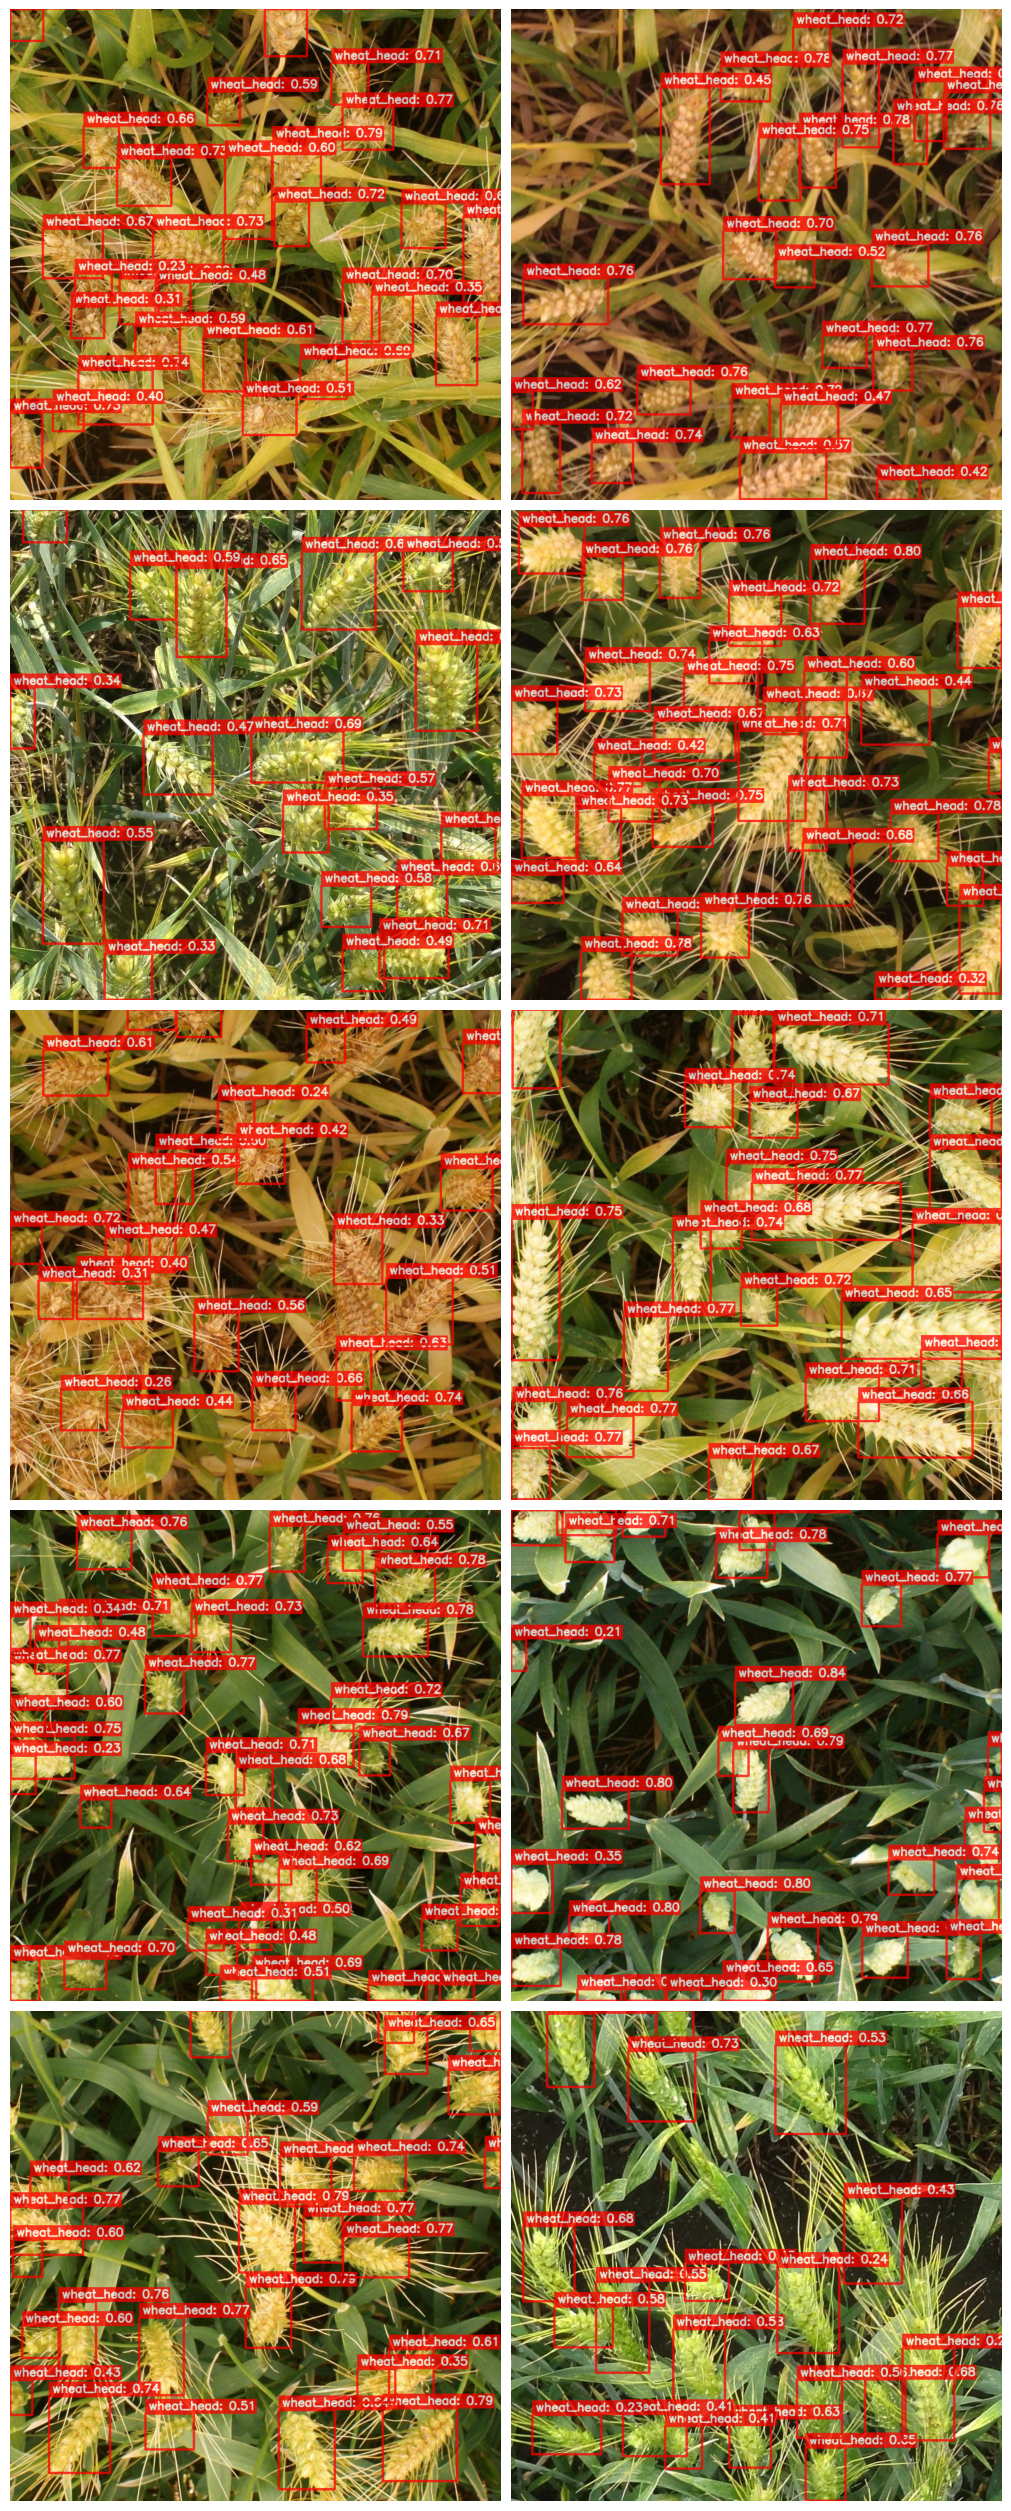

In [17]:
fig = plt.figure(figsize=(10, 25), layout="constrained")

for i,(img_file, box_data, confs) in enumerate(zip(test_image_files, boxes_dict.values(), scores_dict.values())):
    filename = os.path.join(TEST_IMG_DIR, img_file)
    image = cv2.imread(filename)[...,::-1]
    classes = np.zeros(len(box_data), dtype="int")
    image =  draw_bbox(image,
                       box_data,
                       classes,
                       confs,
                       thickness=4)

    ax = plt.subplot(5, 2, i+1)
    plt.imshow(image)
    plt.axis("off")

plt.show()

## Prepare Kaggle Submission `CSV` File

In [18]:
with open('submission.csv', 'w', newline='') as file:
    
    writer = csv.writer(file)
    field = ["image_id","PredictionString"]
    writer.writerow(field)
    
    for image_file in test_image_files:

        image_id = image_file.split(".")[0]
        concat_score_boxes = [[*x, *y] for x, y in zip(scores_dict[image_id], boxes_dict[image_id])]
        flatten_list = list(itertools.chain(*concat_score_boxes))
        
        list_str = " ".join([str(item) for item in flatten_list])
        
        writer.writerow([image_id, list_str])